In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import csv
import nest_asyncio
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from  sklearn.metrics import confusion_matrix, accuracy_score
import emoji
import string
from keras.utils import to_categorical
from ast import literal_eval
from sklearn.metrics import classification_report
nltk.download('stopwords')
nltk.download('punkt')
seed = 10
np.random.seed(seed)
nest_asyncio.apply()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [177]:
def remove_emoji():
    """menghilangkan emoji"""
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

begone_emoji = remove_emoji()

def remove_three_same_char(value):
    """menghilangkan repitisi 3 karakter berurutan seperti gooooool"""
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1\1", value)
def cleaning_text(value):
  result = value.lower().strip()
  result = remove_three_same_char(result)
  result = ' '.join(result.split())
  result = re.sub(r'(@|https?)\S+|#[A-Za-z0-9_]+', '', result).replace("&amp;", "dan")
  result = re.sub(r'RT[\s]+','',result)
  result = begone_emoji.sub(repl='', string=result)
  result = re.sub(r'[0-9]+','',result)
  result = result.replace('\n', ' ')
  result = result.translate(str.maketrans('','',string.punctuation))
  return result

def tokenizing_text(value):
  result= word_tokenize(value)
  return result

def filtering_stopwords(value):
  list_stopwords = set(stopwords.words('indonesian'))
  filtered = []
  for text in value:
    if text not in list_stopwords:
      filtered.append(text)
  return filtered

def stemming_text(value):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  return [stemmer.stem(word) for word in value]

def sentence_make(tokenized):
  return ' '.join(word for word in tokenized)


def remove_slang(value):
    kamus = eval(open("combined_slang_words.txt").read())
    pattern = re.compile(r"\b(%s)\b" % "|".join(kamus))
    converted = pattern.sub(lambda word: kamus.get(word.group()), value)
    # clear = re.sub(r'[^\w\s]', ' ', converted)
    return converted

In [ ]:
df_etle = pd.read_excel('data oktober-des 2022 etilang tanpa lang dan etle.xlsx')
df_etle.head()

In [ ]:
df_etle['tweet_cleaned_id'] = df_etle['text_id'].apply(cleaning_text)
df_etle.head()

In [ ]:
df_etle['tweet_preprocessed'] = df_etle['tweet_cleaned_id'].apply(remove_slang)
df_etle['tweet_preprocessed'] = df_etle['tweet_preprocessed'].apply(tokenizing_text)
df_etle['tweet_preprocessed'] = df_etle['tweet_preprocessed'].apply(filtering_stopwords)
df_etle['tweet_preprocessed'] = df_etle['tweet_preprocessed'].apply(stemming_text)

df_etle.drop_duplicates(subset = 'tweet_cleaned_id', inplace = True )

In [ ]:
df_etle

In [ ]:
df_etle.to_csv('colab_data_clean.csv', index=False, sep=';', header = True, index_label=None)


In [178]:
df_etle = pd.read_csv('colab_data_clean.csv', sep=';')
df_etle.head()

,text_id,tweet_cleaned_id,tweet_preprocessed
0,"Kembangkan ETLE, 7 Polda Dapat Penghargaan di ...",kembangkan etle polda dapat penghargaan di ra...,"['kembang', 'etle', 'polda', 'harga', 'rakerni..."
1,Sosialisasi etle dan app smart city\r\n\r\n#po...,sosialisasi etle dan app smart city,"['sosialisasi', 'etle', 'app', 'smart', 'city']"
2,"Berita populer kumparanOTO, Selasa (13/12) det...",berita populer kumparanoto selasa detail vesp...,"['berita', 'populer', 'kumparanoto', 'selasa',..."
3,"Mimin kasih info ya gaes, kita mau uji coba ET...",mimin kasih info ya gaes kita mau uji coba etl...,"['mimin', 'kasih', 'informasi', 'iya', 'teman'..."
4,personil lalu lintas polres badung melaksanaka...,personil lalu lintas polres badung melaksanaka...,"['personil', 'lintas', 'polres', 'badung', 'la..."


In [ ]:
def lexicon_reader(path: str) -> dict:
    with open(path, 'r') as csv_data:
        bucket = dict()
        reader = list(csv.reader(csv_data, delimiter =","))
        for row in reader[1:]:
        # print(row[0])
            bucket[row[0]] = int(row[1])
    return bucket

def sentiment_lexicon_indonesia(value):
    score = 0
    for word in value:
        word = word.replace("'","")
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]
    if score > 0:
        polarity = 'positif'
    elif score < 0:
        polarity = 'negatif'
    else:
        polarity = 'netral'
    return score, polarity

lexicon_positive = lexicon_reader('positive.csv')
lexicon_negative = lexicon_reader('negative.csv')



In [179]:
def string_to_list(value):
    return literal_eval(value)

In [180]:
dtype = df_etle.dtypes
dtype

text_id               object
tweet_cleaned_id      object
tweet_preprocessed    object
dtype: object

In [181]:
df_etle['tweet_preprocessed'] = df_etle['tweet_preprocessed'].apply(string_to_list)
sentiment = df_etle['tweet_preprocessed'].apply(sentiment_lexicon_indonesia)
sentiment = list(zip(*sentiment))
df_etle['polarity_score'] = sentiment[0]
df_etle['polarity'] = sentiment[1]

#
df_etle['polarity'].info()
df_etle.head()

<class 'pandas.core.series.Series'>
RangeIndex: 7621 entries, 0 to 7620
Series name: polarity
Non-Null Count  Dtype 
--------------  ----- 
7621 non-null   object
dtypes: object(1)
memory usage: 59.7+ KB


,text_id,tweet_cleaned_id,tweet_preprocessed,polarity_score,polarity
0,"Kembangkan ETLE, 7 Polda Dapat Penghargaan di ...",kembangkan etle polda dapat penghargaan di ra...,"[kembang, etle, polda, harga, rakernis, fungsi...",6,positif
1,Sosialisasi etle dan app smart city\r\n\r\n#po...,sosialisasi etle dan app smart city,"[sosialisasi, etle, app, smart, city]",0,netral
2,"Berita populer kumparanOTO, Selasa (13/12) det...",berita populer kumparanoto selasa detail vesp...,"[berita, populer, kumparanoto, selasa, detail,...",7,positif
3,"Mimin kasih info ya gaes, kita mau uji coba ET...",mimin kasih info ya gaes kita mau uji coba etl...,"[mimin, kasih, informasi, iya, teman, uji, cob...",7,positif
4,personil lalu lintas polres badung melaksanaka...,personil lalu lintas polres badung melaksanaka...,"[personil, lintas, polres, badung, laksana, te...",-5,negatif


In [ ]:
df_etle.to_csv('colab_data_clean_polarity.csv', index = False, header = True, index_label = False, sep=';')

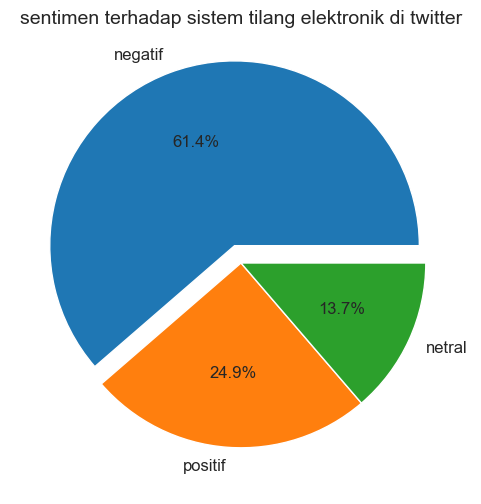

In [182]:
fig, ax = plt.subplots(figsize = (6,6))
sizes = [row for row in df_etle['polarity'].value_counts()]
label = list(df_etle['polarity'].value_counts().index)
explode = (0.1, 0,0)
ax.pie(x=sizes, labels=label, autopct = '%1.1f%%', explode=explode, textprops={'fontsize':12})
ax.set_title('sentimen terhadap sistem tilang elektronik di twitter', fontsize=14)
plt.show()

In [183]:
X = df_etle['tweet_preprocessed'].apply(sentence_make)
max_feature = 5000

tokenizer = Tokenizer(num_words=max_feature, split = ' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)

In [184]:
X.shape

(7621, 53)

In [ ]:
def LSTM_model(input_dim,output_dim,lstm_unit):
    model_lstm = Sequential()
    model_lstm.add(Embedding(input_dim=5000,output_dim=20, input_length=X.shape[1]))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(LSTM(units=20, dropout=0.2, recurrent_dropout=0.2))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(Dense(units=3, activation="softmax"))

    model_lstm.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(model_lstm.summary())
    return model_lstm

# LSTM

## LSTM 1

In [277]:
polarity_encode = {'negatif':0, 'netral':1, 'positif':2 }
# y = df_etle['polarity'].map(polarity_encode).values

y = pd.get_dummies(df_etle['polarity']).values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state = 0)
# y_test = to_categorical(y_test)
# y_train = to_categorical(y_train)

In [278]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_feature,output_dim=64, input_length=X.shape[1]))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(units=3, activation="softmax"))
model_lstm.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_lstm.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 53, 64)            320000    
                                                                 
 dropout_70 (Dropout)        (None, 53, 64)            0         
                                                                 
 lstm_35 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_71 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________


In [279]:
history = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128, verbose=1)
scores = model_lstm.evaluate(X_test, y_test, verbose=False)
print(f"Accuracy: {scores[1]*100} %")
# dir_image_save = "LSTM_file/60_40, 15, 32"


Epoch 1/15
36/36 [==============================] - 9s 122ms/step - loss: 0.9679 - accuracy: 0.5971 - val_loss: 0.8693 - val_accuracy: 0.6136
Epoch 2/15
36/36 [==============================] - 4s 102ms/step - loss: 0.7882 - accuracy: 0.6459 - val_loss: 0.7156 - val_accuracy: 0.6953
Epoch 3/15
36/36 [==============================] - 4s 100ms/step - loss: 0.6445 - accuracy: 0.7441 - val_loss: 0.6059 - val_accuracy: 0.7452
Epoch 4/15
36/36 [==============================] - 4s 103ms/step - loss: 0.5143 - accuracy: 0.7997 - val_loss: 0.5194 - val_accuracy: 0.8026
Epoch 5/15
36/36 [==============================] - 4s 99ms/step - loss: 0.4013 - accuracy: 0.8482 - val_loss: 0.4917 - val_accuracy: 0.8226
Epoch 6/15
36/36 [==============================] - 4s 102ms/step - loss: 0.3300 - accuracy: 0.8828 - val_loss: 0.4497 - val_accuracy: 0.8383
Epoch 7/15
36/36 [==============================] - 4s 101ms/step - loss: 0.2884 - accuracy: 0.8992 - val_loss: 0.4317 - val_accuracy: 0.8436
Epoch 8

In [280]:
import os
# os.makedirs(dir_image_save, exist_ok=True)
y_pred = model_lstm.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
acc = accuracy_score(y_test, y_pred)
print("Model Accuracy in Test Data : ", acc*100,"%")

96/96 [==============================] - 1s 8ms/step
Model Accuracy in Test Data :  85.17546736634962 %


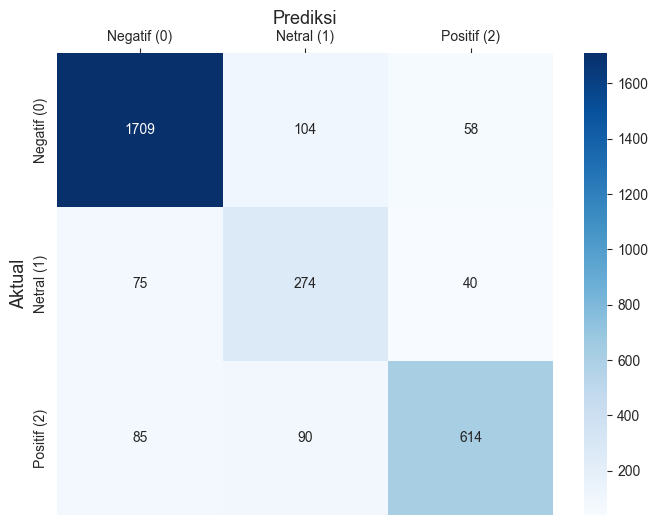

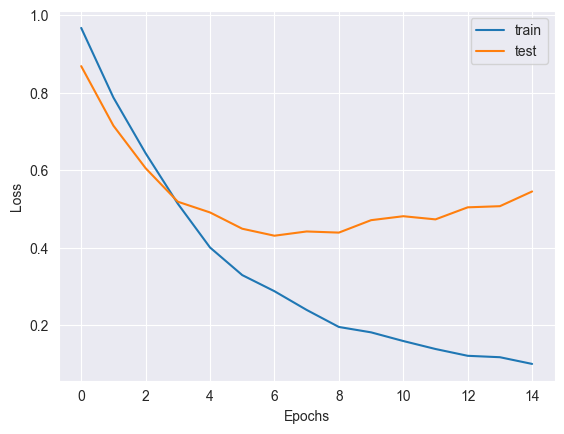

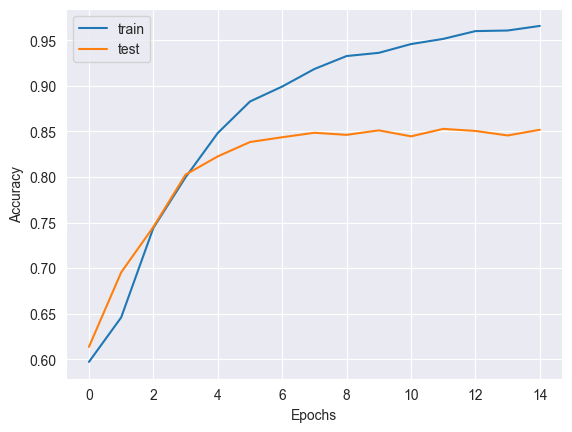

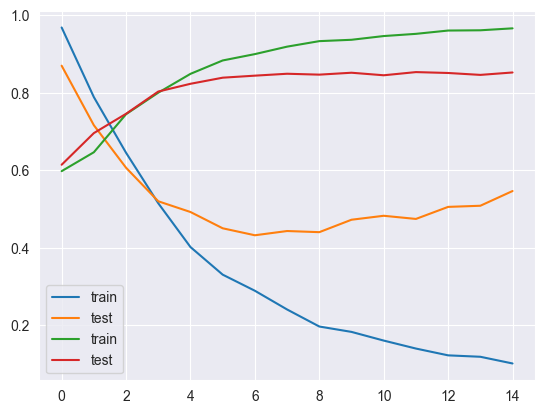

In [281]:

confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), fmt='g', annot=True, cmap='Blues')
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediksi', fontsize=13)
ax.set_xticklabels(['Negatif (0)', 'Netral (1)', 'Positif (2)'])
ax.set_ylabel('Aktual', fontsize=13)
ax.set_yticklabels(['Negatif (0)', 'Netral (1)', 'Positif (2)'])
plt.show()
# plt.imsave(f'{dir_image_save}/CF.png')
# plt.title('Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()
# plt.imsave(f'{dir_image_save}/Loss.png')
# plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()
# plt.imsave(f'{dir_image_save}/Acc.png')

plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


In [ ]:
def save_model(json_name, model_name, model_to_save):
    model_to_json = model_to_save.to_json()
    with open(f"{json_name}.json", 'w') as model_config:
        model_config.write(model_to_json)
    model_to_save.save_weights(f"{model_name}.h5")
    return "saved model to disk"

def plot(model_history, param):
    if param.lower() == 'loss':
        plot_param = 'loss'
        plot_loss = 'val_loss'
    else:
        plot_param = 'accuracy'
        plot_loss = 'val_accuracy'
    plt.title(param)
    plt.plot(model_history.history[plot_param], label = 'train')
    plt.plot(model_history.history[plot_loss], label = 'test')
    plt.legend()
    return plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(history.history['accuracy'], label = 'train_accuracy')
ax.plot(history.history['val_accuracy'], label = 'validation_accuracy')
ax.set_title('Model accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.legend(loc = 'upper left')
plt.show()

In [ ]:
y_pred = model_lstm.predict(X)
y_pred = np.argmax(y_pred, axis=1)
df_etle['value_polarity'] = df_etle['polarity'].apply(lambda row: polarity_encode.get(row))
df_etle['prediction'] = y_pred
df_etle.to_csv('hasil_prediksi.csv', index=False, sep=';')

In [ ]:
y_pred = model_lstm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy on test data: ', accuracy)
confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = y_pred), fmt = 'b', annot=True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 13)
ax.set_xticklabels(['negatif (0)', 'netral (1)', 'positif (2)'])
ax.set_ylabel('Actual', fontsize=13)
ax.set_yticklabels(['negatif (0)', 'netral (1)', 'positif (2)'])
plt.show()